# Image Classification with a Convolutional Neural Network

Notebook created by [Santi Pascual](https://github.com/santi-pdp) for the [UPC School](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) (2019). 

Updated in 2024 by Adrián Ramos González for the 

Based on an original version in Keras created by [Miriam Bellver](https://imatge.upc.edu/web/people/miriam-bellver) for the [Barcelona Technology School](https://barcelonatechnologyschool.com/master/master-in-big-data-solutions/) (BTS) in 2018, and updated by [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/) and [Xavier Giro](https://imatge.upc.edu/web/people/xavier-giro) in 2019 and by [Pol Caselles](https://www.linkedin.com/in/pcaselles/), [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/) and [Juan José Nieto](https://www.linkedin.com/in/juan-jose-nieto-salas/) in 2022.

We will start replicating the imports and Dataset from the last lab (where MLPs were used to classify MNIST images).

In [26]:
import time
import numpy as np

import torch
import torch.nn as nn

from typing import Tuple, Dict, Any, List
from torchvision import datasets, transforms

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import mlx as mlx
import mlx.core as ml # Adding support for Apple Silicon
import mlx.nn.layers as nn_mlx

'''
Notes by Adrian Ramos:
We are using MPS: Metal Performance Shaders to accelerrate operations by using Apple Silicon M3 GPU 
in a nutshell refactor torch.cuda by torch.mps and so. CUDA will only be available at Cluster

Also we use mlx.core as library for hardware accelerated GPU operations. May it also Neral Unit accelerated? Check! Would be amazing
'''

'\nNotes by Adrian Ramos:\nWe are using MPS: Metal Performance Shaders to accelerrate operations by using Apple Silicon M3 GPU \nin a nutshell refactor torch.cuda by torch.mps and so. CUDA will only be available at Cluster\n\nAlso we use mlx.core as library for hardware accelerated GPU operations. May it also Neral Unit accelerated? Check! Would be amazing\n'

In [2]:
if torch.mps.device_count():
    print("We will say this is equivalent to torch.cuda.is_available(), or we can:")
else:
    print("Or maybe not")

We will say this is equivalent to torch.cuda.is_available(), or we can:


In [3]:
ml.metal.is_available()

True

In [4]:
ml.metal.device_info()

{'memory_size': 8589934592,
 'max_recommended_working_set_size': 5726633984,
 'max_buffer_length': 4294967296,
 'architecture': 'applegpu_g15g'}

In [5]:
if False:
    ml.metal.clear_cache() # This is amazing! Do it before fetching the CNN memory.

# Adrian 

For now I am keeping it kernel, because I read that mlx performance is not that surprising. pytorch kernel performs better, so I will stick with it

In [6]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.mps.manual_seed(seed)

In [7]:
# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
device = torch.device('mps') if ml.metal.is_available() else torch.device('cpu')

# whenever we send something to the selected device (X.to(device)) we already use
# either CPU or CUDA (GPU). Importantly...
# The .to() operation is in-place for nn.Module's, so network.to(device) suffices
# The .to() operation is NOT in.place for tensors, so we must assign the result
# to some tensor, like: X = X.to(device)

In [8]:
device

device(type='mps')

### Defining the Hyper-parameters

We now define the hyperparameters that are going to be used throughout the notebook
to define the network, the data `batch_size`, the training `learning_rate`, and others.

In [9]:
# Let's define some hyper-parameters
hparams = {
    'batch_size': 64,
    'num_epochs': 10,
    'test_batch_size': 64,
    'learning_rate': 1e-3,
    'log_interval': 100,
}


# Adrian

Ok Apple Silicon support is available from kernel. Lets follow the lab as it is, as a classifier, then I'd fight with the ASCAT dataset that will be a headache to adapt. 
*Remember* How to work with masked vectors // how to deal with NULL data in the images.

### Defining the PyTorch Dataset and the DataLoader

The [PyTorch Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) is an inheritable `class` that helps us defining what source of data do we have (image, audio, text, ...) and how to load it (overriding the `__getitem__` function). The MNIST dataset is easible accessible from it.

The [PyTorch DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is an iterator that provides batching and shuffling capabilities, among others.

Each of the datasets, `mnist_trainset` and `mnist_testset`, is composed by images and labels. The model will be trained with the former and evaluated with the latter. Our images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging from 0 to 9. There is a one-to-one correspondence between the images and the labels.

In [10]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset initializations

mnist_trainset = datasets.MNIST(
    root='data', 
    train=True, 
    download=True,
    transform=transforms
)
mnist_testset = datasets.MNIST(
    root='data', 
    train=False, 
    download=True,
    transform=transforms
)

# Dataloders initialization

train_loader = torch.utils.data.DataLoader(
    dataset=mnist_trainset,
    batch_size=hparams['batch_size'],
    shuffle=True,
    drop_last=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=mnist_testset,
    batch_size=hparams['test_batch_size'],
    shuffle=False,
    drop_last=True,
)

In [11]:
# We can retrieve a sample from the dataset by simply indexing it
img, label = mnist_trainset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

# Similarly, we can sample a BATCH from the dataloader by running over its iterator
iter_ = iter(train_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print(f'The Batched tensors return a collection of {bimg.shape[0]} grayscale images \
({bimg.shape[1]} channel, {bimg.shape[2]} height pixels, {bimg.shape[3]} width \
pixels)')
print(f'In the case of the labels, we obtain {blabel.shape[0]} batched integers, one per image')

Img shape:  torch.Size([1, 28, 28])
Label:  5
Batch Img shape:  torch.Size([64, 1, 28, 28])
Batch Label shape:  torch.Size([64])
Batch Img shape:  torch.Size([64, 1, 28, 28])
Batch Label shape:  torch.Size([64])
The Batched tensors return a collection of 64 grayscale images (1 channel, 28 height pixels, 28 width pixels)
In the case of the labels, we obtain 64 batched integers, one per image


### About Convolutional Neural Networks

Previously, we trained a network using fully connected layers to classify images. However, in the lectures we learned that when dealing with images, Convolutional Neural Networks (CNNs) are more convenient because they deal better with local correlations in the data (as with images). So now we are going to train a CNN for multiclass classification.

The following lines show what a basic convnet looks like. It's a stack of Conv2D and MaxPooling2D layers.  





# Adrian

## About MLX:

It is a library developed by the Apple AI research team to accelerate operationss by using the GPU. I don't think there will be problems in allocation with MPS, as it is basically the same. Unified memory makes super interesting programing such applications to drain all the available power from the system. As regarding as CPU, Apple Silicon designed by battery saving in mind waste some power allocating lower clock speed to efficiency cores (4 from the total 8). This is translated in lower turbo boosting in comparison to iMac i5 3.1GHz. That is the reason I'm expending some time in getting this straight. 

In [12]:
import mlx.core as ml

In [13]:
# Let's first define a 2D convolutional layer with 1 input channel, 3 output channels 
# and (height=3, width=3) kernel size

if ml.metal.is_available():
    mps_device = torch.device("mps")
    conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3,3),device=mps_device)
else:
    conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3,3)) # This is pytorch core


In [14]:
conv

Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))

Importantly, a convnet takes input tensors of shape `(batch, num_channels, image_height, image_width)`. In our case, we will configure our convnet to process inputs of size `(1, H, W)`, which is the format of MNIST images. 
Let's try with some random image.


In [15]:
conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3,3),padding=1,device=mps_device)

x = torch.rand(1, 1, 28, 28, device=mps_device)
y = conv(x)
print(f"Output shape: {y.shape} = conv({x.shape})")

Output shape: torch.Size([1, 3, 28, 28]) = conv(torch.Size([1, 1, 28, 28]))


In [16]:
x.size()

torch.Size([1, 1, 28, 28])

> Alice: Note that the only actual number we specify from the input data is the number of channels! No image dimensions are given to the convolutional layer. These are just used to shape the data `x`.
>
> Bob: Why is that?
>
> <p>Alice: Because of PyTorch magic &#128526;</p>
>
> <p>Bob: No, seriously. Why? &#128565;</p>
>
> Alice: Because of the dynamic computational graph (DCG)!

**Do you remember all that stuff about a certain dynamic computational graph? Well here it goes in action. Do we need to specify a fixed size for the images as in other frameworks (such as Keras, TensorFlow, etc.) ? Nope. Because we can forward any image size at any time through the same convolutional layer!**

As another example. Let's forward an image of size (11, 11).

In [17]:
x = torch.rand(1, 1, 11, 11,device=mps_device)
y = conv(x)
print(f"Output shape: {y.shape} = conv({x.shape})")

Output shape: torch.Size([1, 3, 11, 11]) = conv(torch.Size([1, 1, 11, 11]))


In [18]:
x.size()

torch.Size([1, 1, 11, 11])

**Tadáaaa**, it did accept the input data, and give a corresponding output shape. **The only argument related to the data required in the convolutional definition is the number of channels.**

### Exercise 1

Why do the output spatial dimensions (`dim=2` and `dim=3`) differ from the input ones? Re-define the `conv` layer below setting the appropriate property such that the output spatial shape is the same as the input one. Also configure it to have three output channels. Look at the PyTorch documentation (`https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d`) for more reference.

# Adrian
## Formula for perfect i-o size match

$$
P=\frac{S[0](H_{in}-1)-H_{in}+D[0](K[0]-1)+1}
{2}
$$

- P: Padding
- S: Stride
- $H_{in}$: Input height
- D[0]: Dilation, deffault is 1, for the first dimension dim0
- K[0]: Kernel_size for dim0

For the below case, we choose to modify the kernel sizes of dimm0 and dimm1, then the formulation goes like:

$$
K[0]=K[1]=1
$$


In [19]:
# TODO: Define the conv layer below and ensure that the output tensor shape in
# dimensions {H, W} ( as in [1, channels, H, W] ) will be the same as the input in both cases.

#conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3,3),device=mps_device)
conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(1,1))

x = torch.rand(1, 1, 20, 20)
y = conv(x)
print(f"Output shape: {y.shape} = conv({x.shape})")

x = torch.rand(1, 1, 11, 11)
y = conv(x)
print(f"Output shape: {y.shape} = conv({x.shape})")

Output shape: torch.Size([1, 3, 20, 20]) = conv(torch.Size([1, 1, 20, 20]))
Output shape: torch.Size([1, 3, 11, 11]) = conv(torch.Size([1, 1, 11, 11]))


### About Pooling

Pooling refers to a block where downsampling happens. In the case of CNNs, as they process full images throughout a certain stack of layers that can get quite deep, they occupy a lot of memory to store the so called feature maps. Feature maps are the intermediate hidden activations of a CNN. The next image ([from a Quora response](https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks)) is very self-explainatory of what **Max Pooling** does applied to images and spatial feature maps.

![](https://qph.fs.quoracdn.net/main-qimg-40cdeb3b43594f4b1b1b6e2c137e80b7)

As you see, it decimates neighboring regions by picking the max value within that region. And that happens for every channel in the feature map (or the image, if it is grayscale/RGB).

The are also other pooling methods, like [`AvgPool2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.AvgPool2d), strided Convolutions (simply incrasing the `stride > 1` of the `torch.nn.Conv2d` layer, etc. Each one has its advantages and drawbacks, which are so far out of the scope of this study on how to define a CNN in PyTorch.

In any case, a good question for now is: **what are the advantages of using pooling of any kind?**

Let's define a small CNN without pooling and another one with pooling, and let's check the amount of memory used by each in terms of feature map usage and the time it takes to forward an image of `512x512` pixels with just `1` input channel (hence greyscale). 

In [20]:
NUM_BITS_FLOAT32 = 32

"""
Let's define a class that encapsulates a collection of layers we pass in
for each forwarded layer, it retains the amount of consumed memory for
the returned feature map. It also displays the total amount used after 
all blocks are ran.
"""
class CNNMemAnalyzer(nn.Module):

    def __init__(self, layers: nn.Module) -> None:
        super().__init__()
        self.layers = layers

    def forward(self, x: torch.Tensor) -> Tuple[float, List[int]]:
        tot_mbytes = 0
        spat_res = []
        for layer in self.layers:
            h = layer(x)
            mem_h_bytes = np.cumprod(h.shape)[-1] * NUM_BITS_FLOAT32 // 8
            mem_h_mb = mem_h_bytes / 1e6
            print('-' * 30)
            print(f'New feature map of shape: {h.shape}')
            print(f'Mem usage: {mem_h_mb} MB')
            x = h
            if isinstance(layer, nn.Conv2d):
                # keep track of the current spatial width for conv layers
                spat_res.append(h.shape[-1])
            tot_mbytes += mem_h_mb
        print('=' * 30)
        print('Total used memory: {:.2f} MB'.format(tot_mbytes))
        return tot_mbytes, spat_res

#### Forwarding the 512x512 image through a non-pooled CNN

In [21]:
# First, make a plain stack of convlayers

mps_device = torch.device("mps")
#conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3,3),device=mps_device)

cnn = CNNMemAnalyzer(
    nn.ModuleList([
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3),device=mps_device),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),device=mps_device),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3),device=mps_device),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),device=mps_device),
        nn.Conv2d(in_channels=128, out_channels=512, kernel_size=(3,3),device=mps_device),
    ])
)

# Let's work with a realistic 512x512 image size
# Also, keep track of time to make forward
beg_t = time.perf_counter()
nopool_mbytes, nopool_res = cnn(torch.randn(1, 1, 512, 512,device=mps_device))

# https://pytorch.org/docs/stable/mps.html
# Waits for all kernels in all streams on a MPS (Apple Silicon) device to complete.
torch.mps.synchronize()

end_t = time.perf_counter()
nopool_time = end_t - beg_t
print('Total inference time for non-pooled CNN: {:.2f} s'.format(nopool_time))

------------------------------
New feature map of shape: torch.Size([1, 32, 510, 510])
Mem usage: 33.2928 MB
------------------------------
New feature map of shape: torch.Size([1, 64, 508, 508])
Mem usage: 66.064384 MB
------------------------------
New feature map of shape: torch.Size([1, 64, 506, 506])
Mem usage: 65.545216 MB
------------------------------
New feature map of shape: torch.Size([1, 128, 504, 504])
Mem usage: 130.056192 MB
------------------------------
New feature map of shape: torch.Size([1, 512, 502, 502])
Mem usage: 516.104192 MB
Total used memory: 811.06 MB
Total inference time for non-pooled CNN: 0.27 s


#### Forwarding the 512x512 image through a pooled CNN

In [22]:
# Now, let's make a stack of convlayers combined with MaxPoolings

mps_device = torch.device("mps")
cnn = CNNMemAnalyzer(
    nn.ModuleList([
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3),device=mps_device),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),device=mps_device),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3),device=mps_device),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),device=mps_device),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels=128, out_channels=512, kernel_size=(3,3),device=mps_device),
        nn.MaxPool2d(kernel_size=(2,2)),
    ])
)

beg_t = time.perf_counter()
pool_mbytes, pool_res = cnn(torch.randn(1, 1, 512, 512,device=mps_device))
torch.mps.synchronize()
end_t = time.perf_counter()
pool_time = end_t - beg_t
print('Total inference time for pooled CNN: {:.2f} s'.format(pool_time))

------------------------------
New feature map of shape: torch.Size([1, 32, 510, 510])
Mem usage: 33.2928 MB
------------------------------
New feature map of shape: torch.Size([1, 32, 255, 255])
Mem usage: 8.3232 MB
------------------------------
New feature map of shape: torch.Size([1, 64, 253, 253])
Mem usage: 16.386304 MB
------------------------------
New feature map of shape: torch.Size([1, 64, 126, 126])
Mem usage: 4.064256 MB
------------------------------
New feature map of shape: torch.Size([1, 64, 124, 124])
Mem usage: 3.936256 MB
------------------------------
New feature map of shape: torch.Size([1, 64, 62, 62])
Mem usage: 0.984064 MB
------------------------------
New feature map of shape: torch.Size([1, 128, 60, 60])
Mem usage: 1.8432 MB
------------------------------
New feature map of shape: torch.Size([1, 128, 30, 30])
Mem usage: 0.4608 MB
------------------------------
New feature map of shape: torch.Size([1, 512, 28, 28])
Mem usage: 1.605632 MB
---------------------

In [23]:
mem_ratio = 1. - pool_mbytes / nopool_mbytes
print('Total saved memory with poolings: ', 100. * mem_ratio)

time_ratio = nopool_time / pool_time
print('Total inference speed increase with poolings: x{:.1f}'.format(time_ratio))

Total saved memory with poolings:  91.20932171879804
Total inference speed increase with poolings: x7.8


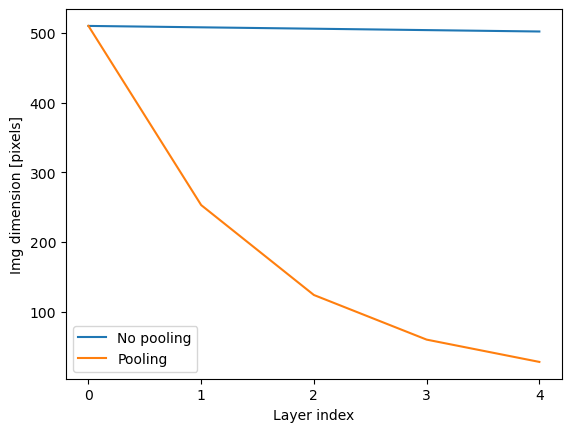

In [24]:
# Let's plot the width of each feature map as we get deeper into the network
plt.plot(nopool_res, label='No pooling')
plt.plot(pool_res, label='Pooling')
plt.xticks(list(range(len(pool_res))))
plt.xlabel('Layer index')
plt.ylabel('Img dimension [pixels]')           
plt.legend()

### Key Observations

* We save 91.2% of memory having a model which is pooling after the first couple of conv layers. 
* The model that contains pooling runs 15.7 times faster in inference than the other one.
* The width dimension decreases exponentially when inserting the poolings, compared to the one without those poolings.

The convolutional operator works by sweeping the kernel filters through the input image. If we pool `x2` in a couple layers, from the 3rd convlayer onwards we have a `x4` smaller spatial resolution. This means it has to run through by far less pixels to process the whole feature map in those layers. Also, each feature occupies much less memory for the reduced resolution. Pooling is hence a practical downsampling to make our nets fit in memory, and also to get the salient features from the previous incoming feature maps (it gets the maximum activation and forwards only that one within a window). In general, for classification, it is usual to have pooling to condense spatial dimensions into less-and-more-abstract ones. This is done by finish processing the last reduced spatial feature map with some fully connected layer that mixes it all up.

## Grand Finale: Building a (pseudo) LeNet model

Here we will gather the puzzle pieces we have so far (tensor manipulations, convs, poolings, fully connected layers, etc.) and we will define a pseudo-LeNet model ([LeNet ref](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)). We say "pseudo" because we will obviate the type of actual pooling that the authors proposed by then, or the gaussian connections, or the `Tanh` activations. We will instead use `MaxPooling`s, `Fully connected` layers all the way through, and `ReLU` activations.

For reference, the LeNet model is the following:
![](https://miro.medium.com/max/2154/1*1TI1aGBZ4dybR6__DI9dzA.png)

### Exercise 2

Make the `ConvBlock` class to properly do: `Conv2d`, `ReLU`, and `MaxPool2d`. Ensure that for an input of size `1x32x32` you obtain an output feature map of size `6x14x14` as shown in the figure above for layer `S2`.

In [28]:
class ConvBlock(nn.Module):

    def __init__(
            self, 
            num_inp_channels: int, 
            num_out_fmaps: int,
            kernel_size: int, 
            pool_size: int=2) -> None:

        super().__init__()

        # TODO: define the 3 modules needed
        self.conv = nn.Conv2d(in_channels=num_inp_channels, out_channels=num_out_fmaps, kernel_size=kernel_size, device=mps_device)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=pool_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.maxpool(self.relu(self.conv(x)))



model = ConvBlock(
    num_inp_channels=1, 
    num_out_fmaps=6, 
    kernel_size=5, 
    pool_size=2)

# run forward pass
x = torch.randn(1, 1, 32, 32, device=mps_device)
y = model(x)

assert y.shape[1] == 6, 'The amount of feature maps is not correct!'
assert y.shape[2] == 14 and y.shape[3] == 14, 'The spatial dimensions are not correct!'
print(f'Input shape: {x.shape}')
print(f'ConvBlock output shape (S2 level in Figure): {y.shape}')

Input shape: torch.Size([1, 1, 32, 32])
ConvBlock output shape (S2 level in Figure): torch.Size([1, 6, 14, 14])


### Exercise 3

Finish the `PseudoLeNet` class by including the following: 
1. As the input images from MNIST are 28x28, add padding to make them 32x32 with the `torch.nn.ConstantPad2d` (https://pytorch.org/docs/stable/nn.html#torch.nn.ConstantPad2d).
2. Build the `mlp` classifier as a `nn.Sequential` stack of fully connected layers and ReLU activations, with the sizes shown in the figure above: [120, 84, 10]. Plug the appropriate output activation in the end to do multi-class classification.
3. Remember to "flatten" the feature maps coming out of the second `ConvBlock` and connect them to the output `mlp` to build the classifier in the `forward` function. This has to be done because fully connected layers (`Linear`) only accept features without any spatial dimension. Hence, all these spatial dimensions and channels are unrolled into single vectors, one per batch sample. **HINT: Remember the `.reshape()` operator to change tensors shape!**

In [32]:
class PseudoLeNet(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        # TODO: Define the zero-padding
        self.pad = torch.nn.ConstantPad2d(2, 0)

        self.conv1 = ConvBlock(num_inp_channels=1, num_out_fmaps=6, kernel_size=5)
        self.conv2 = ConvBlock(num_inp_channels=6, num_out_fmaps=16, kernel_size=5)

        # TODO: Define the MLP at the deepest layers
        self.mlp = nn.Sequential(nn.Linear(400, 120, device=mps_device),
                                 nn.ReLU(),
                                 nn.Linear(120, 84, device=mps_device),
                                 nn.ReLU(),
                                 nn.Linear(84,10, device=mps_device),
                                 nn.LogSoftmax(dim = 1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pad(x)
        x = self.conv1(x)
        x = self.conv2(x)
        # Obtain the parameters of the tensor in terms of:
        # 1) batch size
        # 2) number of channels
        # 3) spatial "height"
        # 4) spatial "width"
        bsz, nch, height, width = x.shape
        # TODO: Flatten the feature map with the reshape() operator
        # within each batch sample
        x = x.view(bsz,-1)

        y = self.mlp(x)
        return y

In [34]:
# Let's forward a toy example emulating the MNIST image size
plenet = PseudoLeNet()
y = plenet(torch.randn(1, 1, 28, 28, device=mps_device))
print(f"Output shape: {y.shape}")

Output shape: torch.Size([1, 10])


### Now it's time to train and test the model. 

We take the previous training and test codes from MLP lab models and run them straightaway. Execute the cells below without more hessitation.

In [35]:
def compute_accuracy(predicted_batch: torch.Tensor, label_batch: torch.Tensor) -> float:
    """
    Define the Accuracy metric in the function below by:
      (1) obtain the maximum for each predicted element in the batch to get the
        class (it is the maximum index of the num_classes array per batch sample)
        (look at torch.argmax in the PyTorch documentation)
      (2) compare the predicted class index with the index in its corresponding
        neighbor within label_batch
      (3) sum up the number of affirmative comparisons and return the summation

    Parameters:
    -----------
    predicted_batch: torch.Tensor shape: [BATCH_SIZE, N_CLASSES]
        Batch of predictions
    label_batch: torch.Tensor shape: [BATCH_SIZE, 1]
        Batch of labels / ground truths.
    """
    pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    acum = pred.eq(label_batch.view_as(pred)).sum().item()
    return acum

In [36]:
def train_epoch(
        train_loader: torch.utils.data.DataLoader,
        network: torch.nn.Module,
        optimizer: torch.optim,
        criterion: torch.nn.functional,
        log_interval: int,
        ) -> Tuple[float, float]:

    # Activate the train=True flag inside the model
    network.train()

    train_loss = []
    acc = 0.
    avg_weight = 0.1
    for batch_idx, (data, target) in enumerate(train_loader):

        # Move input data and labels to the device
        data, target = data.to(device), target.to(device)

        # Set network gradients to 0.
        optimizer.zero_grad()

        # Forward batch of images through the network
        output = network(data)

        # Compute loss
        loss = criterion(output, target)

        # Compute backpropagation
        loss.backward()

        # Update parameters of the network
        optimizer.step()

        # Compute metrics
        acc += compute_accuracy(output, target)
        train_loss.append(loss.item())

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_acc = 100. * acc / len(train_loader.dataset)

    return np.mean(train_loss), avg_acc

In [37]:
@torch.no_grad() # decorator: avoid computing gradients
def test_epoch(
        test_loader: torch.utils.data.DataLoader,
        network: torch.nn.Module,
        ) -> Tuple[float, float]:

    # Dectivate the train=True flag inside the model
    network.eval()
    
    test_loss = []
    acc = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        output = network(data)

        # Apply the loss criterion and accumulate the loss
        test_loss.append(criterion(output, target).item())

        # compute number of correct predictions in the batch
        acc += compute_accuracy(output, target)

    # Average accuracy across all correct predictions batches now
    test_acc = 100. * acc / len(test_loader.dataset)
    test_loss = np.mean(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

In [38]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []
network = PseudoLeNet()
network.to(device)

optimizer = torch.optim.RMSprop(network.parameters(), lr=hparams['learning_rate'])
criterion = nn.NLLLoss(reduction='mean')

for epoch in range(hparams['num_epochs']):

    # Compute & save the average training loss for the current epoch
    train_loss, train_acc = train_epoch(train_loader, network, optimizer, criterion, hparams["log_interval"])
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # TODO: Compute & save the average test loss & accuracy for the current epoch
    # HELP: Review the functions previously defined to implement the train/test epochs
    test_loss, test_accuracy = test_epoch(test_loader, network)

    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.317148
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.347927
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.071498
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.249350
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.097406
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.048164
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.118012
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.109532
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.056260
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.007833

Test set: Average loss: 0.0596, Accuracy: 9779/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.024315
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.122131
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.027924
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.011686
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.049505
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.043837
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.012170
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.069979
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.090534
T

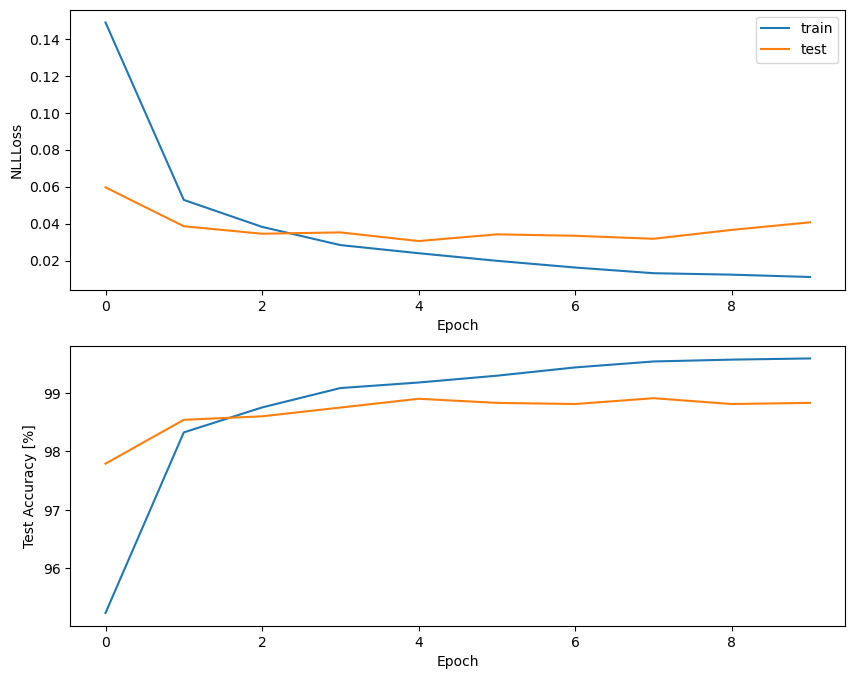

In [39]:
# Plot the plots of the learning curves
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')

### The training accuracy should be slightly above 99%, better than the MLP model for a comparable amount of training.